# Homogeneous Medium

*This example notebook follows the [Homogeneous Propagation Medium Example](http://www.k-wave.org/documentation/example_ivp_homogeneous_medium.php) of [k-Wave](http://www.k-wave.org/).*

## Setup
### Domain

Similarly to k-Wave, j-Wave requires the user to specify a computational domain where the simulation takes place. This is done using the `Domain` dataclass which is lifted from [`jaxdf`](https://github.com/ucl-bug/jaxdf).

The inputs for the constructor are the size of the domain in grid points in each spatial direction, and the corresponding discretization steps.

In [1]:
from jwave.geometry import Domain

N, dx = (128, 128), (0.1e-3, 0.1e-3)
domain = Domain(N, dx)

### Acoustic medium

In this example, the speed of sound has a constant value of $1500m/s$. The speed of sound is defined as part of the `Medium` dataclass, which also needs the computational domain as mandatory input argument

In [2]:
from jwave.geometry import Medium

medium = Medium(domain=domain, sound_speed=1500.0)
print(medium)

Medium:
 - domain: Domain(N=(128, 128), dx=(0.0001, 0.0001))
 - sound_speed: 1500.0
 - density: 1.0
 - attenuation: 0.0
 - pml_size: 20


### Time

Time-stepping simulations requires to define a `TimeAxis` object, which is used by the timestepping scheme of the numerical simulation. To ensure a stable simulation, this object can be constructed from the `medium` object for a given [CFL number](https://it.wikipedia.org/wiki/Condizione_di_Courant-Friedrichs-Lewy).

In [3]:
from jwave.ode import TimeAxis

time_axis = TimeAxis.from_cfl_number(medium, cfl=0.3)

In [4]:
time_axis

TimeAxis(t0=0.0, t1=1.1973674098650615e-05, dt=2e-08)

### Initial pressure

The initial pressure distribution is a Field, therefore it must be somehow represented according to a discretization. Most of the functions of `jwave` are tested using a `FourierSeries` discretization: since in this example we are not interested in tweaking the underlying discretization, we will use this class to define the initial pressure field.

In [5]:
from jax import numpy as jnp

from jwave import FourierSeries
from jwave.geometry import circ_mask

p0 = 1.0 * jnp.expand_dims(circ_mask(N, 4, (80, 60)), -1)
p0 = FourierSeries(p0, domain)

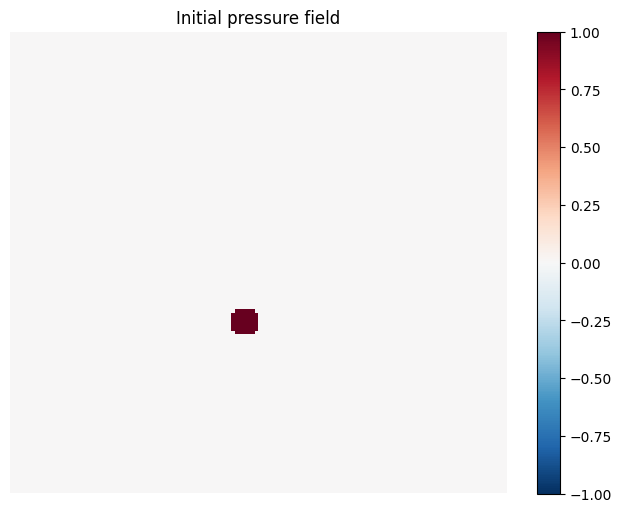

In [6]:
from matplotlib import pyplot as plt

from jwave.utils import show_field

show_field(p0)
plt.title(f"Initial pressure field")
plt.show()

## Run the simulation

In [7]:
from jax import jit

from jwave.acoustics import acoustic_solver
from jwave.ode import SemiImplicitEulerCorrected


def compiled_simulator(medium, p0):
    return acoustic_solver(medium, time_axis, SemiImplicitEulerCorrected(),  p0=p0)

In [8]:
pressure = compiled_simulator(medium, p0)

/home/antonio/repos/jwave/jwave/acoustics/time_varying.py:287: UserWarning: Both sensors and saveat.fn are set. The latter will be overwritten
  warnings.warn(


TypeError: Shapes must be 1D sequences of concrete values of integer type, got (Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>,).
If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.
The error occurred while tracing the function diffeqsolve at /home/antonio/anaconda3/envs/jwave/lib/python3.11/site-packages/equinox/_jit.py:32 for jit. This value became a tracer due to JAX operations on these lines:

  operation a[35m:f32[][39m = convert_element_type[new_dtype=float32 weak_type=False] b
    from line /home/antonio/repos/jwave/jwave/acoustics/time_varying.py:525:15 (acoustic_solver)

  operation a[35m:f32[][39m = convert_element_type[new_dtype=float32 weak_type=False] b
    from line /home/antonio/repos/jwave/jwave/acoustics/time_varying.py:525:15 (acoustic_solver)

In [ ]:
t = 250
show_field(pressure[t])
plt.title(f"Pressure field at t={time_axis.to_array()[t]}")
plt.show()

## Timings

In [ ]:
%timeit compiled_simulator(medium, p0).params.block_until_ready()